In [117]:
from sklearn.datasets import load_wine
from sklearn.cluster import KMeans
import random

from lib.baseline import *
from lib.baycon import execute

from lib.CF_De.cfde import CF_Descent
from lib.cf_a.cfae import CF_Ascent
from dataclasses import dataclass
from lib.eval.generator import run
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Cross testing of methods

In [118]:
X, true_y = load_wine(return_X_y=True)
nc = 3
km = KMeans(n_clusters=nc)
y = km.fit_predict(X)
centers = km.cluster_centers_
print(centers)

@dataclass
class CounterfactualData:
    cf: np.array
    instance: np.array
    target: float
    instance_label: float

n = 1
cfs = []
for i in range(n):
    index = random.randint(0, len(X)-1)
    label = y[index]
    target = label
    while target == label:
        target = random.randint(0, nc-1)
    
    cfs.append(CounterfactualData([], index, float(target), label))

[[1.26025000e+01 2.46360000e+00 2.32930000e+00 2.06960000e+01
  9.37400000e+01 2.05040000e+00 1.63350000e+00 3.98700000e-01
  1.42190000e+00 4.69479999e+00 9.11900000e-01 2.38170000e+00
  5.17750000e+02]
 [1.38136667e+01 1.77866667e+00 2.49866667e+00 1.69666667e+01
  1.05366667e+02 2.91566667e+00 3.10700000e+00 2.94000000e-01
  1.96233333e+00 6.11033333e+00 1.09600000e+00 3.00000000e+00
  1.28773333e+03]
 [1.33218750e+01 2.41979167e+00 2.36145833e+00 1.85729167e+01
  1.08729167e+02 2.41708333e+00 2.18020833e+00 3.27500000e-01
  1.71083333e+00 5.15729167e+00 9.65750000e-01 2.84812500e+00
  8.86250000e+02]]


## Baseline

In [119]:
from lib.baseline import baseline_explainer
from lib.baycon import baycon_explainer
from sklearn.ensemble import RandomForestClassifier

explainer = baycon_explainer
baseline_cfs = []
for cf in cfs:
    classifier = RandomForestClassifier(n_estimators=100)
    baseline_cf = baseline_explainer(X, y, classifier, explainer, cf.instance, target_cluster=int(cf.target))
    baseline_cfs.append(CounterfactualData(baseline_cf, cf.instance, cf.target, cf.instance_label))

Done training classifier. Score: 1.0
--- Executing... Initial Instance: 22 Target: 0 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (612) CFs (0)
Re-training surrogate model with data size: 612
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (8) Unique overall (8)
Generated random instances: (2648)
Predicted top: 20 Counterfactuals: 4
Found new best [1.176417e+01 1.860000e+00 2.360000e+00 1.660000e+01 1.010000e+02
 2.610000e+00 2.538720e+00 2.700000e-01 1.690000e+00 3.800000e+00
 1.110000e+00 4.000000e+00 4.713500e+02], with fitness score 0.6965 (X 0.9054 Y 1.0 F 0.76923), oversampling
Known alternatives: 632
Best instance score 0.6965 (X 0.9054 Y 1.0 F 0.76923), found on epoch: 1
Re-training surrogate model with data size: 642
--- epoch 2 ----
Generating neighbors for 20 near best instances
Generated neighbours: (45) Unique overall (53

## Baycon

In [120]:
from lib.ext.baycon.common.Target import Target
baycon_cfs = []
modes = ['classic_baycon', 'kmeans', 'model_agnostic']
run_mode = modes[2]


if run_mode == modes[0]:
    model = RandomForestClassifier()
elif run_mode == modes[1]:
    model = KMeans(n_clusters=3)
elif run_mode == modes[2]:
    model = KMeans(n_clusters=3)
    # model = SpectralClustering(n_clusters=3)
else:
    raise("Invalid baycon mode")
model.fit(X, y)
pred = model.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

baycon_cfs = []
for cf in cfs:
    point_idx = cf.instance
    point_pred = int(model.predict([X[point_idx]])[0])
    if run_mode == modes[0]:
        t = Target(target_type="classification", target_feature="label", target_value=int(cf.target))
    elif run_mode == modes[1]:
        t = Target(target_type="clustering_kmeans", target_feature="label", target_value=int(cf.target))
    elif run_mode == modes[2]:
        t = Target(target_type="model_agnostic", target_feature="label", target_value=int(cf.target))

    baycon_cf, _predictions, _initial_instance, _initial_prediction = execute(df, model, t, point_idx)
    baycon_cfs.append(CounterfactualData(baycon_cf, cf.instance, cf.target, cf.instance_label))

--- Executing... Initial Instance: 22 Target: 0 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (611) CFs (569)
Re-training surrogate model with data size: 611
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (22) Unique overall (22)
Generated random instances: (2659)
Predicted top: 20 Counterfactuals: 20
Found new best [1.371000e+01 1.860000e+00 2.360000e+00 1.660000e+01 1.010000e+02
 2.610000e+00 2.125440e+00 2.700000e-01 1.690000e+00 3.800000e+00
 1.110000e+00 2.816275e+00 1.035000e+03], with fitness score 0.2589 (X 0.95611 Y 0.32 F 0.84615), oversampling
Known alternatives: 631
Best instance score 0.2589 (X 0.95611 Y 0.32 F 0.84615), found on epoch: 1
Re-training surrogate model with data size: 641
--- epoch 2 ----
Generating neighbors for 20 near best instances
Generated neighbours: (69) Unique overall (75)
Generated random instances

## CFDE

In [121]:
cfde_cfs = []
amount = 20
for cf in cfs:
    temp_cfs = []
    for i in range(amount):
        x1, cf1, h1 = CF_Descent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20)
        temp_cfs.append(cf1)
    cfde_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))    

cfde_cfs

[CounterfactualData(cf=[array([1.26025000e+01, 2.46360000e+00, 2.32930000e+00, 1.66000000e+01,
        1.01000000e+02, 2.05040000e+00, 2.88000000e+00, 3.98700000e-01,
        1.42190000e+00, 3.79907277e+00, 9.11900000e-01, 4.00000000e+00,
        6.78694207e+02]), array([1.35052760e+01, 2.46360000e+00, 2.32930000e+00, 1.66000000e+01,
        1.01000000e+02, 2.05040000e+00, 2.88000000e+00, 3.98700000e-01,
        1.42190000e+00, 4.69479999e+00, 9.11900000e-01, 4.00000000e+00,
        6.57972044e+02]), array([1.26025000e+01, 2.46360000e+00, 2.32930000e+00, 1.66000000e+01,
        1.01000000e+02, 2.05040000e+00, 2.88000000e+00, 3.98700000e-01,
        1.42190000e+00, 3.79846959e+00, 9.11900000e-01, 4.00000000e+00,
        6.71388292e+02]), array([1.37104334e+01, 2.46360000e+00, 2.32930000e+00, 1.66000000e+01,
        1.01000000e+02, 2.05040000e+00, 2.88000000e+00, 3.98700000e-01,
        1.42190000e+00, 4.69479999e+00, 9.11900000e-01, 4.00000000e+00,
        6.79366691e+02]), array([1.260

## CFAE

In [122]:
cfae_cfs = []
amount = 20
for cf in cfs:
    temp_cfs = []
    for i in range(amount):
        x2, cf2, h2 = CF_Ascent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20)
        temp_cfs.append(cf2)
    cfae_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))

cfae_cfs

[CounterfactualData(cf=[array([1.37100000e+01, 1.86000000e+00, 2.36000000e+00, 1.66000000e+01,
        1.01000000e+02, 2.61000000e+00, 2.88000000e+00, 2.70000000e-01,
        1.69000000e+00, 3.80000000e+00, 1.11000000e+00, 4.00000000e+00,
        7.07842866e+02]), array([1.37100000e+01, 1.86000000e+00, 2.36000000e+00, 1.66000000e+01,
        1.01000000e+02, 2.61000000e+00, 2.88000000e+00, 2.70000000e-01,
        1.69000000e+00, 3.80000000e+00, 1.11000000e+00, 4.00000000e+00,
        7.10697721e+02]), array([1.37100000e+01, 1.86000000e+00, 2.36000000e+00, 1.66000000e+01,
        1.01000000e+02, 2.61000000e+00, 2.88000000e+00, 2.70000000e-01,
        1.69000000e+00, 3.80000000e+00, 1.11000000e+00, 4.00000000e+00,
        7.13960576e+02]), array([1.37100000e+01, 1.86000000e+00, 2.36000000e+00, 1.66000000e+01,
        1.01000000e+02, 2.61000000e+00, 2.88000000e+00, 2.70000000e-01,
        1.69000000e+00, 3.80000000e+00, 1.11000000e+00, 4.00000000e+00,
        7.04221947e+02]), array([1.371

## Testing

In [123]:
baseLine = {
    "name": "Baseline",
    "counterfactuals": baseline_cfs
}
Baycon = {
    "name": "Baycon",
    "counterfactuals": baycon_cfs
}
cfde = {
    "name": "CF-DE",
    "counterfactuals": cfde_cfs
}
cfae = {
    "name": "CF-AE",
    "counterfactuals": cfae_cfs
}

methods = [baseLine, Baycon, cfde, cfae]
results, names = run(methods, centers, X, y)


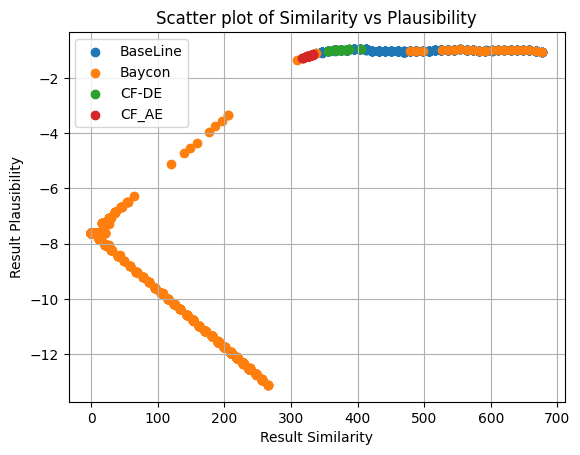

In [124]:
def plot(f1, f2, results_list, names):
    method_names = ["BaseLine", "Baycon", "CF-DE", "CF_AE"]
    for idx, results in enumerate(results_list):
        result_x = [row[f1] for row in results]
        result_y = [row[f2] for row in results]

        plt.scatter(result_x, result_y, label=f"{method_names[idx]}")

    # Adding title and labels
    plt.title(f"Scatter plot of {names[f1]} vs {names[f2]}")
    plt.xlabel(f"Result {names[f1]}")
    plt.ylabel(f"Result {names[f2]}")
    plt.grid(True)

    # Show the legend to distinguish between different datasets
    plt.legend()
    plt.show()

plot(0,2, [results["Baseline"], results["Baycon"], results["CF-DE"], results["CF-AE"]], names)

<Axes: >

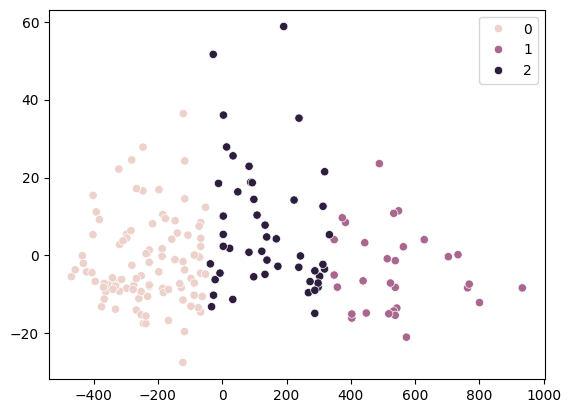

In [125]:
pca = PCA(n_components=2)
embed_X = pca.fit_transform(X)
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)

<Axes: >

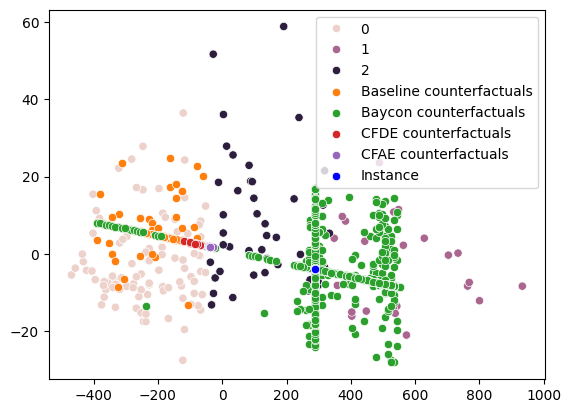

In [ ]:
cf_n = 0
baseline_embed = [pca.transform(v.cf) for v in baseline_cfs][cf_n]
baycon_embed = [pca.transform(v.cf) for v in baycon_cfs][cf_n]
cfde_embed = [pca.transform(v.cf) for v in cfde_cfs][cf_n]
cfae_embed = [pca.transform(v.cf) for v in cfae_cfs][cf_n]
instance_embedded = pca.transform(X[[baseline_cfs[cf_n].instance]])

ins_c = baseline_cfs[cf_n].instance_label
target_c = baseline_cfs[cf_n].target

plt.title(f"Instance from cluster {ins_c} into {target_c}")
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)
sns.scatterplot(x=baseline_embed[:,0], y=baseline_embed[:,1], label="Baseline counterfactuals")
sns.scatterplot(x=baycon_embed[:,0], y=baycon_embed[:,1], label="Baycon counterfactuals")
sns.scatterplot(x=cfde_embed[:,0], y=cfde_embed[:,1], label="CFDE counterfactuals")
sns.scatterplot(x=cfae_embed[:,0], y=cfae_embed[:,1], label="CFAE counterfactuals")
sns.scatterplot(x=instance_embedded[:,0], y=instance_embedded[:,1], label="Instance", color="blue")
